# Zona incerta region (ZIR) structural connectivity

## Python libraries

In [1]:
import numpy as np
import nibabel as nib
import nilearn.plotting, nilearn.surface
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

import os

## Variables

In [2]:
# Study variables
HEMI = "L"
SEED = "ZIR"
TEMPLATE = "MNI152NLin6Asym"
DATA_FNAME = f"tpl-{TEMPLATE}_hemi-{HEMI}_label-{SEED}_desc-concat_from-group_connMap.npz"
DATA_PATH = f"../results/diffparc/tpl-{TEMPLATE}/"

In [3]:
# Surface variables
lh_mmp = nilearn.surface.load_surf_data("../resources/lh.HCPMMP1.annot")
rh_mmp = nilearn.surface.load_surf_data("../resources/rh.HCPMMP1.annot")

## Analysis

### Left
#### Target

In [4]:
data_L = np.load(f"{DATA_PATH}/{DATA_FNAME}");

conn_group = data_L['conn_group']
mask = data_L['mask']
affine = data_L['affine']

# Concat subjects
conn_group_m = np.moveaxis(conn_group, 0, 2)
conn_concat = conn_group_m.reshape(
    [conn_group_m.shape[0], conn_group_m.shape[1]*conn_group_m.shape[2]]
)

In [5]:
# Run spectral clustering
method = 'spectralcosine'
dist = 'cosine'
k = 6 #@param {type:"slider", min:0, max:50, step:1}

clustering = SpectralClustering(
    n_clusters=k, 
    assign_labels="discretize",
    random_state=0,
    affinity=dist,
).fit(conn_concat)

In [6]:
# avg over subjects (for cluster centroid visualization over cortex)
conn_avg =  np.squeeze(np.mean(conn_group_m, 2))

# Cluster
ntargets = conn_group.shape[2]
centroids = np.zeros((k,ntargets))

print(f"shape conn_avg: {conn_avg.shape}")
print(f"shape conn_concat: {conn_concat.shape}")

shape conn_avg: (1669, 180)
shape conn_concat: (1669, 540)


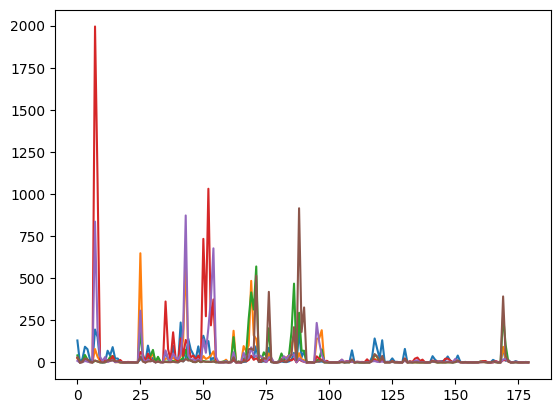

In [7]:
# Get features for each label and average over voxwels
for kidx in range(k):
    centroids[kidx][:] = np.mean(conn_avg[clustering.labels_ == kidx][:], axis=0)
    
    # Plot for centroid
    plt.plot(centroids[kidx])

# use lh_mmp to map to the maximal region from each centroid
target_labels = np.argmax(centroids, 0) + 1

#lh_mmp indices are from 1 to 180 (0 is bgnd), so:
centroid_cortex = target_labels[lh_mmp-1]

In [8]:
# Download fsaverage surface
fsaverage_data = nilearn.datasets.fetch_surf_fsaverage(
    mesh="fsaverage",
    data_dir="../resources/fsaverage"
)

#### Seed

In [9]:
seed_labels_vol = np.zeros(mask.shape)
seed_labels_vol[mask > 0] = clustering.labels_ + 1 #add a 1 so label 0 is diff from bgnd
seed_labels_nib = nib.Nifti1Image(seed_labels_vol,affine)

bg_nib = nib.load('/home/ROBARTS/tkai/graham/projects/ctb-akhanf/jclau/zona_OSF/OSF/SNSX32NLin2020Asym/sub-SNSX32NLin2020Asym_T1map.nii.gz')

In [69]:
# Slices need to be updated
seed_labels_crop = seed_labels_nib.slicer[100:150, 140:180, 80:200]
bg_crop = bg_nib.slicer[100:150, 140:180, 80:200]

## Figures

In [11]:
view = nilearn.plotting.view_surf(surf_mesh=fsaverage_data.get("pial_left"),
                                  surf_map=centroid_cortex,
                                  cmap='tab10',
                                  vmin=0, vmax=k,
                                  symmetric_cmap=False,
                                  colorbar_fontsize=15)
view.open_in_browser()

In [ ]:
# Use cropped image
view = nilearn.plotting.view_img(
    stat_map_img=seed_labels_crop,
    bg_img=bg_crop,
    cmap="tab10",
    vmin=0, vmax=k,
    symmetric_cmap=False,
    threshold=None,
    colorbar_fontsize=15
)

view.open_in_browser()

/srv/khan/users/tkai/opt/venv/zonaconn-smk-Q0hj_50n-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/srv/khan/users/tkai/opt/venv/zonaconn-smk-Q0hj_50n-py3.8/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
